# Crossview Localisation (CVM-Net)

This notebook is a step by step instruction on how to download and run the code from the paper "CVM-Net: Cross-View Matching Network for Image-Based Ground-to-Aerial Geo-Localisation" (Hu et al., 2018). The code can be acessed via the authors' github page: https://github.com/david-husx/crossview_localisation. This instruction is part of our presentation on "Geolocation" for the seminar "Deep Learning for Computer Vision" from the Cognitive Science program at University of Osnabrück. The author of this notebook is Bianca Pfahl (bpfahl@uos.de).

## 1. Requirements


- Python (tested with Python 3)
- Tensorflow 1.x (code is not Tensorflow 2 compatible)
- 16 GB (model) + 23 GB (CVUSA datset) + Bonus: >30 GM (Vo & Hays dataset)

In [11]:
# libraries that are needed for nice display in the notebook
from PIL import Image
import csv
import pandas as pd
from matplotlib import pyplot as plt

# libraries needed for running and testing the networks
from cvm_net import cvm_net_I, cvm_net_II
from input_data import InputData
import tensorflow as tf
import numpy as np

## 2. Downloading the model and the data set(s)

First of all, clone the repository from the authors github page (https://github.com/david-husx/crossview_localisation) to your local machine.

### The Model
The authors provide two versions of the CVM-Net in their repository: CVM-Net-I and CVM-Net-II. <br>
Both models can be downloaded here: https://drive.google.com/file/d/1JtXz4q0kONNoEFE9tEfSCxLRuuJUWqIF/view. <br> Once you have unzipped `CVM-Net_model.zip`, add both the `CVM-Net-I` folder and `CVM-Net-II` folder to `...\crossview_localisation-master\src\Model`.


### CVUSA Dataset
The CVUSAdataset contains pairs of ground-level images and satellite images. In total 35,532 image pairs were used for training and 8,884 image pairs for testing. <br> All ground images are panoramas.

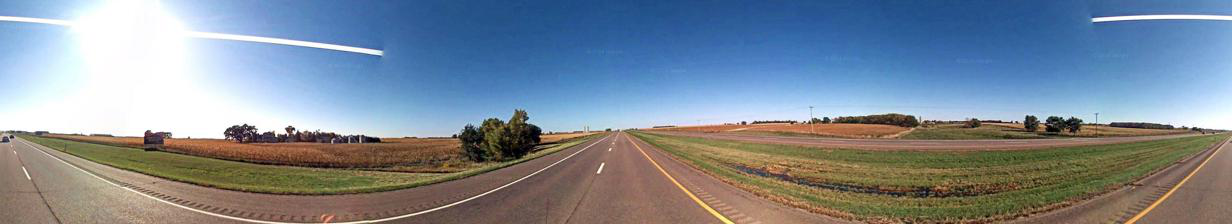

In [2]:
# ground-level image example
streetview_example = Image.open(r'D:\Deep Computer Vision\crossview_localisation-master\src\Data\CVUSA\streetview\panos\0000127.jpg')
display(streetview_example)

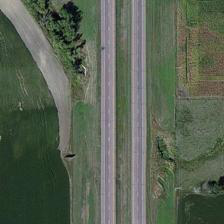

In [3]:
# matching aerial image 
aerial_example = Image.open(r'D:\Deep Computer Vision\crossview_localisation-master\src\Data\CVUSA\bingmap\18\0000127.jpg')
display(aerial_example)

The dataset can be downloaded here: https://drive.google.com/drive/folders/0BzvmHzyo_zCAX3I4VG1mWnhmcGc and has to be added to the following folder: `.../crossview_localisation-master\src\Data\CVUSA`. 
The tricky part for me was noticing that `bingmap.tar.gz`, `streetview.tar.gz` and `splits.tar.gz` actually have to be unzipped **twice** to get to the raw data. The `bingmap` folder then holds all aerial images and the `streetview`folder all ground-level panorama images. In the `splits` folder, the true mappings from streeview to aerial image are stored in the form of .csv-files in which one row represents an image pairing. <br><br>
Example line of `val-19zl.csv`:

In [4]:
with open(r'D:\Deep Computer Vision\crossview_localisation-master\src\Data\CVUSA\splits\val-19zl.csv') as f:
    reader = csv.reader(f)
    print(next(reader))

['bingmap/19/0001227.jpg', 'streetview/panos/0001227.jpg', 'streetview/annotations/0001227.png']


### Vo & Hays (2016) data set (optional)

Vo and Hays’ dataset consists of around one million image pairs from 9 different cities. It can be downloaded here: https://www.mediafire.com/folder/f4gga3h86d659/GTCrossView. After unzipping, the data has to be added to the following folder: `.../crossview_localisation-master\src\Data`. As the data set is quite big (all .zip-files together are already > 33 GB), I did not use this data set for testing the network in this demo. However, you can of course use it when running the authors' original `train.py` to train the network on these image pairs yourself.  

## 3. Testing the Network


With the scripts that can be found in `..\crossview_localisation-master\src\CVM-Net`, the user can train the network on the original data by running `train.py`. By plugging in your own data in the same format as the original data and with a corresponding .csv-file that matches the pairs, it should also be possible to train the network on your own personalized data. However, there is unfourtunately no script that simply tests the performance of the already trained and downloaded network - which is really not ideal, as the whole point of providing your code publically should be so that others can recreate your data.

In the following, I will provide code to test the downloaded network on the validation data. As the original `train.py` script does not only train the network but tests the network's performance after each training epoch, I gathered the code snippets that are required for testing and put them together. 
This notebook is best run from the location `..\crossview_localisation-master\src\CVM-Net` which is where all other scripts are stored.

### Parameter Setting

The batch size has a huge effect on how much RAM will be used up by running the model. In the beginning, I just set the `batch_size = 12` as the authors describe it in the paper which caused the whole program to crash on my computer due to memory constraints. As the code is written in TensorFlow 1, it did not even throw an error nor did it display a helpful error message. It just stopped at some point for no apparent reason. Setting the batch size then to something way smaller (like 1) did the trick. <br>
For `network_type`, we have two options: either 'CVM-NET-I' or 'CVM-NET-II'

In [5]:
network_type = 'CVM-NET-II'
batch_size = 1
is_training = False

### Get the data

The following cell is an excerpt from `input_data.py` and will be called in the back when running the model. In the constructor of `InputData`, you can specify from where you want to read in the meta data (rows with corresponding image pair labels). Here is where it is 

In [6]:
%%script false --no-raise-error # prevents this cell from being run as it is just an excerpt of the real InputData class

class InputData:

    img_root = '../Data/CVUSA/'


    def __init__(self):

        self.train_list = self.img_root + 'splits/train-19zl.csv'
        self.test_list = self.img_root + 'splits/val-19zl.csv'

        print('InputData::__init__: load %s' % self.train_list)
        self.__cur_id = 0  # for training
        self.id_list = []
        self.id_idx_list = []
        with open(self.train_list, 'r') as file:
            idx = 0
            for line in file:
                data = line.split(',')
                pano_id = (data[0].split('/')[-1]).split('.')[0]
                # satellite filename, streetview filename, pano_id
                self.id_list.append([data[0], data[1], pano_id])
                self.id_idx_list.append(idx)
                idx += 1
        self.data_size = len(self.id_list)
        print('InputData::__init__: load', self.train_list, ' data_size =', self.data_size)

Couldn't find program: 'false'


And here we  actually load the Data:

In [7]:
input_data = InputData()
sat_x = tf.placeholder(tf.float32, [None, 512, 512, 3], name='sat_x')
grd_x = tf.placeholder(tf.float32, [None, 224, 1232, 3], name='grd_x')
keep_prob = tf.placeholder(tf.float32)

InputData::__init__: load ../Data/CVUSA/splits/train-19zl.csv
InputData::__init__: load ../Data/CVUSA/splits/train-19zl.csv  data_size = 35532
InputData::__init__: load ../Data/CVUSA/splits/val-19zl.csv
InputData::__init__: load ../Data/CVUSA/splits/val-19zl.csv  data_size = 8884


### The Model


In [8]:
# importing relevant networks to built upon
from VGG import VGG16
import loupe as lp
from siamese_fc import Siamese_FC
from transnet_v2 import TransNet


def cvm_net_I(x_sat, x_grd, keep_prob, trainable):
    with tf.device('/gpu:1'):
        vgg_grd = VGG16()
        grd_local = vgg_grd.VGG16_conv(x_grd, keep_prob, trainable, 'VGG_grd')
        with tf.variable_scope('netvlad_grd'):
            netvlad_grd = lp.NetVLAD(feature_size=512, max_samples=tf.shape(grd_local)[1] * tf.shape(grd_local)[2],
                                     cluster_size=64, output_dim=4096, gating=True, add_batch_norm=False,
                                     is_training=trainable)
            grd_vlad = netvlad_grd.forward(grd_local)

        vgg_sat = VGG16()
        sat_local = vgg_sat.VGG16_conv(x_sat, keep_prob, trainable, 'VGG_sat')
        with tf.variable_scope('netvlad_sat'):
            netvlad_sat = lp.NetVLAD(feature_size=512, max_samples=tf.shape(sat_local)[1] * tf.shape(sat_local)[2],
                                     cluster_size=64, output_dim=4096, gating=True, add_batch_norm=False,
                                     is_training=trainable)
            sat_vlad = netvlad_sat.forward(sat_local)

    with tf.device('/gpu:0'):
        fc = Siamese_FC()
        sat_global, grd_global = fc.siamese_fc(sat_vlad, grd_vlad, trainable, 'dim_reduction')

    return sat_global, grd_global


def cvm_net_II(x_sat, x_grd, keep_prob, trainable):
    with tf.device('/gpu:1'):
        vgg_grd = VGG16()
        grd_local = vgg_grd.VGG16_conv(x_grd, keep_prob, trainable, 'VGG_grd')

        vgg_sat = VGG16()
        sat_local = vgg_sat.VGG16_conv(x_sat, keep_prob, trainable, 'VGG_sat')

        transnet = TransNet()
        trans_sat, trans_grd = transnet.transform(sat_local, grd_local, keep_prob, trainable,
                                                  'transformation')

        with tf.variable_scope('netvlad') as scope:
            netvlad_sat = lp.NetVLAD(feature_size=512, max_samples=tf.shape(trans_sat)[1] * tf.shape(trans_sat)[2],
                                     cluster_size=64, output_dim=4096, gating=True, add_batch_norm=False,
                                     is_training=trainable)
            sat_global = netvlad_sat.forward(trans_sat, True)

            scope.reuse_variables()

            netvlad_grd = lp.NetVLAD(feature_size=512, max_samples=tf.shape(trans_grd)[1] * tf.shape(trans_grd)[2],
                                     cluster_size=64, output_dim=4096, gating=True, add_batch_norm=False,
                                     is_training=trainable)
            grd_global = netvlad_grd.forward(trans_grd, True)

    return sat_global, grd_global


# use network as chosen in the parameter setting part 
if network_type == 'CVM-NET-I':
    sat_global, grd_global = cvm_net_I(sat_x, grd_x, keep_prob, is_training)
elif network_type == 'CVM-NET-II':
    sat_global, grd_global = cvm_net_II(sat_x, grd_x, keep_prob, is_training)
else:
    print ('CONFIG ERROR: wrong network type, only CVM-NET-I and CVM-NET-II are valid')

VGG16: trainable = False
VGG16: trainable = False
TransNet: trainable = False


### Validation Function

The network computes a vector representation for every image it has seen. In the validation step, every aerial image is compared to every ground-level image and the distances between their vector representation is computed. The match with the lowest distance should - ideally - correspond to the true match.

In [9]:
# validation function from train.py
def validate(grd_descriptor, sat_descriptor):
    accuracy = 0.0
    data_amount = 0.0
    dist_array = 2 - 2 * np.matmul(sat_descriptor, np.transpose(grd_descriptor))
    # for illustration
    heatmap = plt.pcolor(dist_array)
    plt.colorbar(heatmap)
    top1_percent = int(dist_array.shape[0] * 0.01) + 1
    for i in range(dist_array.shape[0]):
        gt_dist = dist_array[i, i]
        prediction = np.sum(dist_array[:, i] < gt_dist)
        if prediction < top1_percent:
            accuracy += 1.0
        data_amount += 1.0
    accuracy /= data_amount

    return accuracy, heatmap

### Running the Model & Testing Performance

In this demo, I will test the model using the first 20 image pairs from the test data set.

load model...
   Model loaded from: ../Model/CVM-NET-II/model.ckpt
load model...FINISHED
validate...
   compute global descriptors
      progress 0
      progress 1
      progress 2
      progress 3
      progress 4
      progress 5
      progress 6
      progress 7
      progress 8
      progress 9
      progress 10
      progress 11
      progress 12
      progress 13
      progress 14
      progress 15
      progress 16
      progress 17
      progress 18
      progress 19
   compute accuracy 

test accuracy = 5.0%


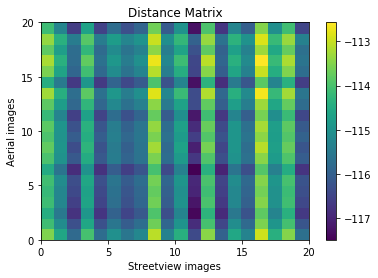

In [10]:
config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())

    print('load model...')
    load_model_path = '../Model/' + network_type + '/model.ckpt'
    print("   Model loaded from: %s" % load_model_path)
    print('load model...FINISHED')

    # ---------------------- validation ----------------------
    print('validate...')
    print('   compute global descriptors')
    input_data.reset_scan()
    sat_global_descriptor = np.zeros([input_data.get_test_dataset_size(), 4096])
    grd_global_descriptor = np.zeros([input_data.get_test_dataset_size(), 4096])
    max_batches = 20
    val_i = 0
    while True:
        print('      progress %d' % val_i)
        batch_sat, batch_grd = input_data.next_batch_scan(batch_size)
        if (batch_sat is None):
            break
        feed_dict = {sat_x: batch_sat, grd_x: batch_grd, keep_prob: 1.0}
        sat_global_val, grd_global_val = \
            sess.run([sat_global, grd_global], feed_dict=feed_dict)

        sat_global_descriptor[val_i: val_i + sat_global_val.shape[0], :] = sat_global_val
        grd_global_descriptor[val_i: val_i + grd_global_val.shape[0], :] = grd_global_val
        val_i += sat_global_val.shape[0]
        if  (val_i >= max_batches):
            break

    print('   compute accuracy \n')
    val_accuracy, heatmap = validate(grd_global_descriptor[:max_batches,:], sat_global_descriptor[:max_batches,:])
    print('test accuracy = %.1f%%' % (val_accuracy*100.0))
    
    # make the distance matrix plot informative and pretty
    plt.title('Distance Matrix')
    plt.xlabel('Streetview images')
    plt.ylabel('Aerial images')
    plt.locator_params(axis="both", integer=True, tight=True)

## 4. Interpreting the Results

As the validation function checks whether the diagonal elements of the distance matrix ( -> which corresponds to the correct ground-level/aerial match) is in fact the smallest in its column (-> thus cross-checking how well the image matches all images in the database), the diagonal line should ideally show the darkest cells of the heatmap. An image is counted as correctly matched (`accuracy += 1`) if the truely matching image appears in the top 1% guesses. As you can (probably) see above: with a small amount of test images (20-200), I was unable to replicate the accuracy levels Hu et al. reported in their paper. 

## 5. References

- Sixing Hu, Mengdan Feng, Rang M. H. Nguyen, Gim Hee Lee. CVM-Net: Cross-View Matching Network for Image-Based Ground-to-Aerial Geo-Localization. In IEEE Conference on Computer Vision and Pattern Recognition (CVPR), June 2018. (https://github.com/david-husx/crossview_localisation )
- Vo, Nam & Hays, James. (2016). Localizing and Orienting Street Views Using Overhead Imagery. (https://github.com/lugiavn/gt-crossview)